In [1]:
import math
from __future__ import division
from collections import OrderedDict
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
import histbook as hb
from vega import VegaLite as canvas

job_server = ("ifdb01.fnal.gov", 8765)
session = Session(job_server)

In [2]:
bg_datasets = """
Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8
""".split()
bg_datasets = [ds.strip() for ds in bg_datasets if ds.strip()]

In [20]:
import fnal_column_analysis_tools.lookup_tools as lookup_tools
import cloudpickle
import zlib

# import a bunch of correction histograms
weightsext = lookup_tools.extractor()
correctionDescriptions = open("newCorrectionFiles.txt").readlines()
weightsext.add_weight_sets(correctionDescriptions)
weightsext.finalize()
weights_eval = weightsext.make_evaluator()
#let's pickle and zip it
weights_names = zlib.compress(cloudpickle.dumps(weightsext._extractor__names))
weights_vals = zlib.compress(cloudpickle.dumps(weightsext._extractor__weights))
weval_pickle = zlib.compress(cloudpickle.dumps(weights_eval))
#dir(weights_eval)
#print(weights_eval["muScaleFactor_TightId_Iso"])

In [4]:
all_hists = OrderedDict()
cat = hb.groupby("category", keeporder=True)

def add_1d(*args):
    h = hb.Hist(hb.bin(*args), cat)
    all_hists[args[0]] = h
    return h

add_1d("leadingLeptonPt", 100, 0, 500)
add_1d("zMass", 120, 0, 120)

display_opts = {'width': 300, 'height': 300}
def buildDisplay(hists, cols=2):
    rows = []
    for iRow in range(int(math.ceil(len(hists)/cols))):
        hrowname = hists.keys()[iRow*cols:(iRow+1)*cols]
        hrow = hists.values()[iRow*cols:(iRow+1)*cols]
        rows.append(hb.beside(*tuple(h.overlay("category").step(n, **display_opts) for h,n in zip(hrow, hrowname))))
    return IPythonDisplay(
        hb.below(*tuple(rows))
    )
    
display = buildDisplay(all_hists)

class Callback:
    def __init__(self, display):
        self.Display = display
        
    def on_histogram_update(self, nevents):
        self.Display.update()

profile = hb.Hist(hb.bin("stripeThroughput", 100, 0, 5.e5), hb.groupby("operation", keeporder=True))

In [40]:
#__worker_class__
        
# break sandbox
# https://stackoverflow.com/questions/33880646/access-module-sys-without-using-import-machinery
sys = next(getattr(c, f).__func__.__globals__['sys'] for c in ().__class__.__base__.__subclasses__() for f in dir(c) if isinstance(getattr(c, f, None), type((lambda: 0).__get__(0))) and 'sys' in getattr(c, f).__func__.__globals__)
if 'sandbox' in sys.modules:
    __builtins__['__import__'] = sys.modules['sandbox'].saved_import
    import importlib
    sys.modules['sandbox'].safe_modules['fnal_column_analysis_tools'] = importlib.import_module('fnal_column_analysis_tools')
    #import subprocess
    #raise Exception(subprocess.check_output("pip list".split(" ")))
    
import numpy as np
import awkward
import uproot_methods
import cloudpickle
import zlib
import time
from collections import OrderedDict
from functools import reduce
from fnal_column_analysis_tools.analysis_objects import JaggedDecoratedFourVector
from fnal_column_analysis_tools.striped import ColumnGroup, PhysicalColumnGroup


def jaggedFromColumnGroup(cgroup):
    if isinstance(cgroup,PhysicalColumnGroup):
        return JaggedDecoratedFourVector.fromcounts(counts = cgroup.counts(),
                                                    p4 = cgroup.p4Column(),
                                                    **cgroup.otherColumns())
    else:
        return awkward.JaggedArray.fromcounts(cgroup.counts(),
                                              awkward.Table(cgroup.columns()))
    
class Worker(object):
    def __init__(self):
        self.Columns = ["Electron.charge", "Electron.p4", "Electron.tightID",
                        "Muon.charge", "Muon.p4", "Muon.tightID",
                        "Trigger.pass"]
        self._weights_cached = None
        
    def run(self, events, job):
        times = OrderedDict()
        times['start'] = time.time()
        
        try:
            weights_eval = job['weights_eval_c']
        except KeyError:
            weights_eval = cloudpickle.loads(zlib.decompress(job["weights_eval"]))
            job.UserParams['weights_eval_c'] = weights_eval
            
            
        times['cache weights'] = time.time()

        #35: HLT_Ele32_WPTight_Gsf_v
        #36: HLT_Ele35_WPTight_Gsf_v
        #45: HLT_IsoMu20_v
        #46: HLT_IsoMu22_v
        #48: HLT_IsoMu24_v
        #50: HLT_IsoMu27_v
        #only care about processing events which have triggered
        #events_triggered = events.filter()
        trigger_bits = getattr(events.Trigger, "pass").reshape(-1, events.Trigger.count[0])
        good_trigger = trigger_bits[:,[35,36,45,46,48,50]].sum(axis=1) > 0
        
        times['trigger'] = time.time()
        #events = events_triggered(events)
        
        electronCols = PhysicalColumnGroup(events,"Electron","p4","charge","tightID")
        electrons_new = jaggedFromColumnGroup(electronCols)  
        electrons_new['SF'] = weights_eval["eleScaleFactor_TightId_POG"](electrons_new.p4.eta,
                                                                         electrons_new.p4.pt)
        times['electron'] = time.time()

        muonCols = PhysicalColumnGroup(events,"Muon","p4","charge","tightID")
        muons_new = jaggedFromColumnGroup(muonCols)
        muons_new['SF'] = weights_eval["muScaleFactor_TightId_Iso"](np.absolute(muons_new.p4.eta),
                                                                    muons_new.p4.pt)
        
        times['muon'] = time.time()
        
        selected_electrons = electrons_new[(electrons_new.p4.pt > 20) &
                                           (np.absolute(electrons_new.p4.eta) < 2.5) &
                                           (electrons_new.tightID > 0)]
        
        selected_muons = muons_new[(muons_new.p4.pt > 20) &
                                   (np.absolute(muons_new.p4.eta) < 2.5) &
                                   (muons_new.tightID > 0)]
        
        dielectrons = selected_electrons.distincts()
        dimuons = selected_muons.distincts()
# slower        
#         dielectrons = electrons_new.distincts()
#         dielectron_selection = (dielectrons.at(0).p4.pt > 20) & (dielectrons.at(1).p4.pt > 20) \
#                         & (np.abs(dielectrons.at(0).p4.eta) < 2.5) & (np.abs(dielectrons.at(1).p4.eta) < 2.5) \
#                         & (dielectrons.at(0).tightID > 0) & (dielectrons.at(1).tightID > 0)
        
#         dimuons = muons_new.distincts()
#         dimuon_selection = (dimuons.at(0).p4.pt > 20) & (dimuons.at(1).p4.pt > 20) \
#                         & (np.abs(dimuons.at(0).p4.eta) < 2.5) & (np.abs(dimuons.at(1).p4.eta) < 2.5) \
#                         & (dimuons.at(0).tightID > 0) & (dimuons.at(1).tightID > 0)
        
        times['good distinct'] = time.time()
        
        selected_dielectrons = dielectrons[ ((dielectrons.at(0).p4.pt > 38) | (dielectrons.at(1).p4.pt > 38))]
        selected_dimuons = dimuons[good_trigger & ((dimuons.at(0).p4.pt > 30) | (dimuons.at(1).p4.pt > 30))]

        zee_cat = ((selected_dielectrons.counts == 1) & 
                   (selected_dimuons.counts == 0))
        
        times['cats'] = time.time()
        
        #fill electrons
        job.fill(
            category="ee",
            leadingLeptonPt=np.maximum(selected_dielectrons[zee_cat].at(0).p4.pt,
                                       selected_dielectrons[zee_cat].at(1).p4.pt).flatten()
        )        
        job.fill(
            category="ee",
            zMass=selected_dielectrons[zee_cat].p4.mass.flatten()
        )

        zmm_cat = ((selected_dimuons.counts == 1) & 
                   (selected_dielectrons.counts == 0) &
                   good_trigger)
        #fill muons
        job.fill(
            category="mm",
            leadingLeptonPt=np.maximum(selected_dimuons[zmm_cat].at(0).p4.pt,
                                       selected_dimuons[zmm_cat].at(1).p4.pt).flatten()
        )        
        job.fill(
            category="mm",
            zMass=selected_dimuons[zmm_cat].p4.mass.flatten()
        )
           
        #fill both
        job.fill(
            category="all",
            leadingLeptonPt=np.hstack([np.maximum(selected_dimuons[zmm_cat].at(0).p4.pt,
                                                  selected_dimuons[zmm_cat].at(1).p4.pt).flatten(), 
                                       np.maximum(selected_dielectrons[zee_cat].at(0).p4.pt,
                                                  selected_dielectrons[zee_cat].at(1).p4.pt).flatten()]),
        )
        job.fill(
            category="all",            
            zMass=np.hstack([selected_dielectrons[zee_cat].p4.mass.flatten(), 
                             selected_dimuons[zmm_cat].p4.mass.flatten()])
        )
        
        times['plots'] = time.time()
        
        #profiling info
        for i,(name,t) in enumerate(times.iteritems()):
            if i==0:
                continue
            dt = t - times.values()[i-1]
            job.fill(
                operation=name,
                stripeThroughput=(len(events.Muon.count)/dt),
            )
        job.fill(
                operation="total",
                stripeThroughput=(len(events.Muon.count)/(times.values()[-1]-times.values()[0])),
            )

Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8         45.014 M events,   3.496 M events/sec


Total events processed: 45013666 in 13.0 seconds -> 3.456515 million events/second


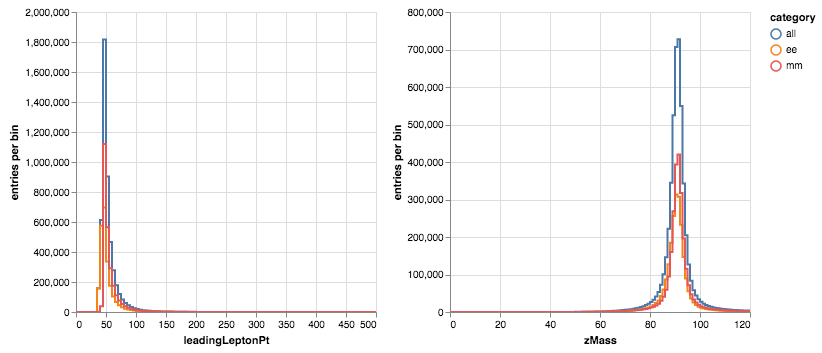

In [41]:
display.init()
callback = Callback(display)
_ = map(lambda h: h.clear(), all_hists.values())
profile.clear()

import time
nevents_total = 0
t1 = time.time()
for dataset in bg_datasets:
    job = session.createJob(dataset, 
            fraction=1.,
            user_callback=callback, 
            user_params = {"weights_names":weights_names,
                           "weights_vals":weights_vals,
                           "weights_eval": weval_pickle},
            histograms=all_hists.values()+[profile]
    )
    job.run()
    runtime = job.TFinish - job.TStart
    nevents = job.EventsProcessed
    nevents_total += nevents
    print "%-70s %7.3f M events, %7.3f M events/sec" % (dataset[:70], float(nevents)/1e6, nevents/runtime/1000000)
    #print "%s: %.6f million events/second" % (dataset, nevents/runtime/1000000)
    display.update()

t2 = time.time()
print "Total events processed: %d in %.1f seconds -> %.6f million events/second" %(nevents_total, t2-t1, nevents_total/(t2-t1)/1000000)

In [7]:
def moment(df, n, binval='mid'):
    """
        df: DataFrame with single-level MultiIndex specifying binning, and a shape of (nbins, )
        n: n-th moment of distribution, ignoring (over/under/nan)flow bins
        binval in ['left', 'right', 'mid']: point in the bin to use as bin value
    """
    vals = np.array([getattr(b, binval) for b in df.index if type(b) is not str])[1:-1]
    weights = np.array(df)[1:-2]  # ignore nanflow (last bin)
    moment = sum(pow(vals, n)*weights) / sum(weights)
    return moment

def mean(df, binval='mid'):
    return moment(df, 1, binval)

def std(df, binval='mid'):
    return np.sqrt(max(moment(df, 2, binval) - moment(df, 1, binval)**2, 0.))

In [35]:
stripeThroughput = mean(profile.pandas()['count()']["total"])
nWorkers = 180
processingTime = nevents_total/stripeThroughput/nWorkers
print "Stripe processing throughput: %.0f evt/s" % stripeThroughput
print "Total throughput: %.0f evt/s" % (nevents_total/(t2-t1), )
print "Striped server overhead: %.1f %%" % ((1-processingTime/(t2-t1))*100, )

Stripe processing throughput: 30498 evt/s
Total throughput: 3444617 evt/s
Striped server overhead: 37.3 %


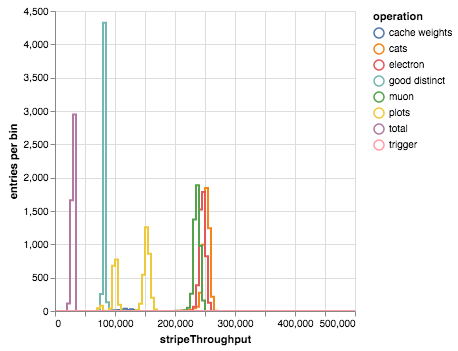

In [34]:
profile.overlay("operation").step("stripeThroughput", **display_opts).to(canvas)

In [33]:
a = profile.pandas()
for n in a.index.levels[0]:
    print "%20s %.0f" % (n, mean(a['count()'][n]))

       cache weights 116167
                cats 251968
            electron 245945
       good distinct 82351
                muon 236630
               plots 133493
               total 30498
             trigger nan


/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
